In [2]:
import gymnasium as gym
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

from collections import deque
import time
import random

from IPython import display
from IPython.display import HTML
import pygame
from base64 import b64encode
import matplotlib.pyplot as plt
import imageio
from time import sleep
import tqdm
import os

In [3]:
RANDOM_SEED = 5
tf.random.set_seed(RANDOM_SEED)

## Inicializa o Enviroment

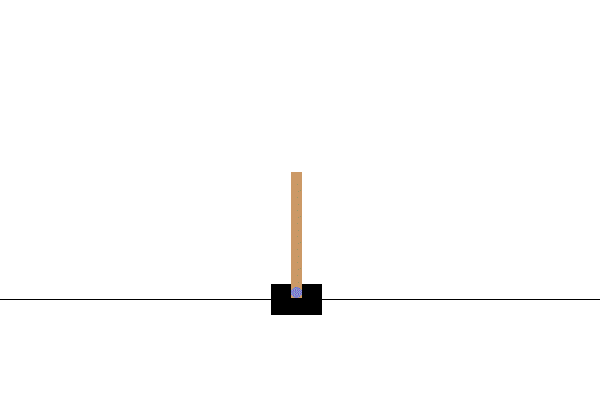

In [5]:
env = gym.make('CartPole-v1')

# A semente agora é definida na primeira vez que você reinicia o ambiente
observation, info = env.reset(seed=RANDOM_SEED)

# Opcional: Se você usa env.action_space.sample(),
# é uma boa prática fixar a semente do espaço de ações também:
env.action_space.seed(RANDOM_SEED)

5

In [6]:
print("Action Space: {}".format(env.action_space))
print("State space: {}".format(env.observation_space))

Action Space: Discrete(2)
State space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)


In [7]:
# Parâmetros do Modelo
num_actions = env.action_space.n
num_states = env.observation_space.shape[0]
learning_rate = 0.01

In [32]:
# Criação do modelo de política
def create_policy_model():
    model = tf.keras.Sequential([
        layers.Dense(24, activation='relu', input_shape=(int(num_states),)),
        layers.Dense(24, activation='relu'),
        layers.Dense(int(num_actions), activation='softmax') # Conversão feita aqui
    ])
    return model

# Função para obter uma ação com base na política atual
def get_action(state):
    state = state.reshape([1, num_states])
    probabilities = policy_model(state)
    action = np.random.choice(num_actions, p=np.squeeze(probabilities))
    return action

# Função para calcular o retorno descontado
def compute_returns(rewards, gamma=0.99):
    returns = np.zeros_like(rewards)
    G = 0
    for t in reversed(range(len(rewards))):
        G = rewards[t] + gamma * G
        returns[t] = G
    return returns

# Treinamento do Modelo
def train(env, policy_model, optimizer, num_episodes=1000, gamma=0.99):
    all_returns = []

    for episode in range(num_episodes):
        # 1. CORREÇÃO: Desempacotar a tupla retornada pelo reset()
        state, _ = env.reset()
        episode_states = []
        episode_actions = []
        episode_rewards = []

        done = False
        while not done:
            action = get_action(state)

            # 2. CORREÇÃO: O step agora retorna 5 valores (terminated e truncated separam o antigo 'done')
            next_state, reward, terminated, truncated, _ = env.step(action)

            # O episódio acaba se a tarefa for concluída (terminated) ou o tempo estourar (truncated)
            done = terminated or truncated

            episode_states.append(state)
            episode_actions.append(action)
            episode_rewards.append(reward)
            state = next_state

        episode_returns = compute_returns(episode_rewards, gamma)
        all_returns.append(sum(episode_rewards))

        episode_states = np.array(episode_states)
        episode_actions = np.array(episode_actions)
        episode_returns = np.array(episode_returns)

        with tf.GradientTape() as tape:
            action_probs = policy_model(episode_states, training=True)
            indices = np.array([np.arange(len(episode_actions)), episode_actions]).T
            action_probs = tf.gather_nd(action_probs, indices)
            loss = -tf.reduce_mean(tf.math.log(action_probs) * episode_returns)

        grads = tape.gradient(loss, policy_model.trainable_variables)
        optimizer.apply_gradients(zip(grads, policy_model.trainable_variables))

        if episode % 50 == 0:
            total_rewards = sum(episode_rewards)
            print(f"Episode {episode}: Total Reward: {total_rewards}")
            if total_rewards == 500:
                break

    return all_returns

def play_episode(images, video_path):
    # 1. Debug: Vamos ver quantos frames o modelo conseguiu sobreviver
    print(f"Total de frames capturados: {len(images)}")

    if len(images) < 10:
        print("Aviso: O vídeo tem pouquíssimos frames! O agente perdeu muito rápido.")

    # 2. Garantir que as imagens sejam do tipo uint8 (padrão de cores de 0 a 255)
    # Isso evita que o ffmpeg se perca e crie um arquivo corrompido/vazio
    processed_images = [np.array(img, dtype=np.uint8) for img in images]

    kargs = { 'macro_block_size': 1 }

    # 3. Salvando o vídeo
    try:
        imageio.mimsave(video_path, processed_images, fps=15, **kargs)
        print(f"Vídeo salvo com sucesso em: {video_path}")
    except Exception as e:
        print(f"Erro ao salvar o vídeo: {e}")


In [16]:
policy_model = create_policy_model()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [21]:
num_episodes = 2000
returns = train(env, policy_model, optimizer, num_episodes)

Episode 0: Total Reward: 28.0
Episode 50: Total Reward: 28.0
Episode 100: Total Reward: 126.0
Episode 150: Total Reward: 16.0
Episode 200: Total Reward: 8.0
Episode 250: Total Reward: 9.0
Episode 300: Total Reward: 8.0
Episode 350: Total Reward: 10.0
Episode 400: Total Reward: 10.0
Episode 450: Total Reward: 10.0
Episode 500: Total Reward: 10.0
Episode 550: Total Reward: 10.0
Episode 600: Total Reward: 9.0
Episode 650: Total Reward: 10.0
Episode 700: Total Reward: 10.0
Episode 750: Total Reward: 11.0
Episode 800: Total Reward: 10.0
Episode 850: Total Reward: 9.0
Episode 900: Total Reward: 9.0
Episode 950: Total Reward: 10.0
Episode 1000: Total Reward: 10.0
Episode 1050: Total Reward: 9.0
Episode 1100: Total Reward: 10.0
Episode 1150: Total Reward: 8.0
Episode 1200: Total Reward: 9.0
Episode 1250: Total Reward: 9.0
Episode 1300: Total Reward: 10.0
Episode 1350: Total Reward: 10.0
Episode 1400: Total Reward: 10.0
Episode 1450: Total Reward: 9.0
Episode 1500: Total Reward: 9.0
Episode 155

In [35]:
# 1. CORREÇÃO: Você precisa recriar o ambiente definindo o render_mode aqui
env = gym.make('CartPole-v1', render_mode='rgb_array')

total_test_rewards = 0
# 2. CORREÇÃO: Desempacotar a tupla do reset
observation, info = env.reset()
images = []
done = False
i = 0
max_steps = 1000
render = True

while not done:
    i += 1
    if i > max_steps:
      break

    if render:
        # 3. CORREÇÃO: Chamar o render sem o parâmetro 'mode'
        img = env.render()
        images.append(img)

    encoded = observation
    encoded_reshaped = encoded.reshape([1, encoded.shape[0]])

    # O verbose=0 aqui é opcional, mas evita que o Keras polua seu terminal a cada passo
    predicted = policy_model.predict(encoded_reshaped, verbose=0).flatten()
    action = np.argmax(predicted)

    # 4. CORREÇÃO: Receber os 5 retornos do step e calcular o 'done'
    new_observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    observation = new_observation
    total_test_rewards += reward

    if done:
        print('Total test rewards: {}'.format(total_test_rewards))
        # (Nota: total_test_rewards += 1 parece desnecessário aqui,
        # mas mantive caso você tenha uma lógica específica para isso)

env.close()

Total test rewards: 10.0


In [37]:
pygame.quit()

In [38]:
video_path = "replay.mp4"
play_episode(images, video_path)
mp4 = open(video_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

Total de frames capturados: 10
Vídeo salvo com sucesso em: replay.mp4


Total de frames capturados: 10
Vídeo salvo com sucesso em: replay.gif



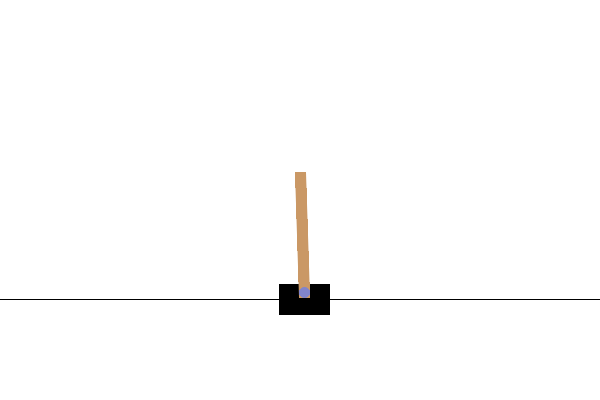

In [39]:
gif_path = "replay.gif"

# Chama a nossa função passando o caminho com a nova extensão
play_episode(images, gif_path)

# Lê o arquivo GIF gerado
gif_file = open(gif_path, 'rb').read()

# Codifica para base64 usando o MIME type de imagem
data_url = "data:image/gif;base64," + b64encode(gif_file).decode()

# Renderiza usando a tag <img> em vez da tag <video>
HTML("""
<img src="%s" width="400" alt="CartPole Agent Replay" />
""" % data_url)